In [1]:
import numpy as np
import oceanDAS as odas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal
import cmocean

%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

# load useful info like depth and noise floor freq for each site
h, f_noise, clrs = odas.all_line_info()

def calcPSD(rawstrain,metadata,frq_noise):
#     frq_noise = odas.calcnoisefloor(rawstrain,metadata)
    rawstrain = (rawstrain - rawstrain[0])/(1e-6) #microStrain to strain for units
    frq_w,psd_w = signal.welch(rawstrain,fs=metadata['fs'],window='hann',nperseg=metadata['fs']*60,detrend=False)
    psd_w = 20*np.log10(psd_w); # dB rel uE
    psd_w[frq_w>frq_noise]=np.nan
    return frq_w,psd_w


In [10]:
# Load in one channel at each site (or load stack and take out one channel)
# Duck
pname = 'DuckNC_Glover/'
fname = 'decimator_2021-11-20_20.25.43_UTC_001612.h5'
rawstrain,das_time,chnl,depth_array,metadata = odas.loadDuck(pname,fname)
ns,nx = rawstrain.shape
rawstrain = rawstrain[:,int(nx/2)]
frq_w,psd_w = signal.welch(rawstrain,fs=metadata['fs'],window='hann',nperseg=metadata['fs']*60,detrend=False)

/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_13785/1069166694.py:6: RuntimeWarning: divide by zero encountered in divide
  L,_ = odas.dispersion(depth,1/f_psd)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_submarine_das/oceanDAS.py:295: RuntimeWarning: divide by zero encountered in power
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_submarine_das/oceanDAS.py:295: RuntimeWarning: invalid value encountered in multiply
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_submarine_das/oceanDAS.py:302: RuntimeWarning: overflow encountered in cosh
  dfdk = - g * np.tanh(k * h) - g * h * k * (1 / np.cosh(k * h)) ** 2
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_13785/1069166694.py:7: RuntimeWarning: overflow enco

(0.0, 2.0)

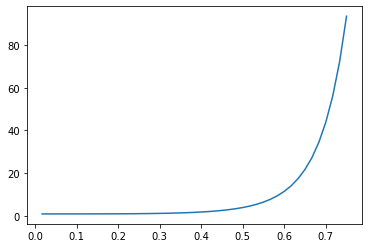

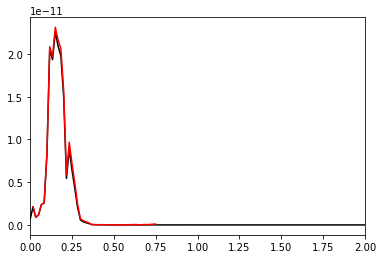

In [16]:


depth = np.abs(depth_array[int(nx/2)])
nperseg = 512
f_psd, ds_psd = signal.welch(rawstrain,fs=metadata['fs'],nperseg=metadata['fs']*60)

# translate bed to surface
L,_ = odas.dispersion(depth,1/f_psd)
attenuation = np.cosh((1/L)*depth)**2 # square for energy
attenuation[attenuation>120] = np.nan # cut it off when correction too big,don't amplify noise
ds_psd_corr = ds_psd*attenuation


plt.figure()
plt.plot(f_psd,attenuation)

plt.figure()
plt.plot(f_psd,ds_psd,'k')
plt.plot(f_psd,ds_psd_corr,'r')
plt.xlim([0,2])
# plt.ylim([0,1])


/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_13785/3032739837.py:4: RuntimeWarning: overflow encountered in exp
  attenuation = np.exp(k*z)
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_13785/3032739837.py:5: RuntimeWarning: overflow encountered in square
  attenuation = attenuation**2


(0.0, 2.0)

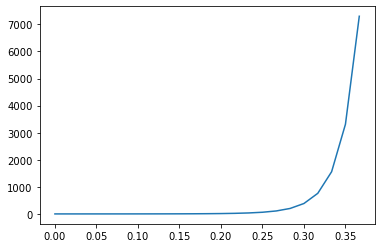

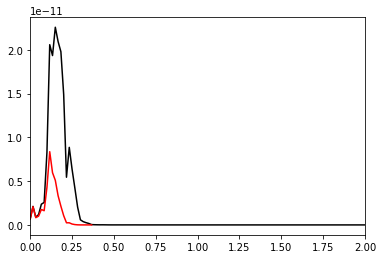

In [26]:
z = np.abs(depth_array[int(nx/2)])

k = (2*np.pi*f_psd)**2 / 9.8
attenuation = np.exp(k*z)
attenuation = attenuation**2
attenuation[attenuation>10000] = np.nan

plt.figure()
plt.plot(f_psd,attenuation)
ds_psd_corr = ds_psd/attenuation
plt.figure()
plt.plot(f_psd,ds_psd,'k')
plt.plot(f_psd,ds_psd_corr,'r')
plt.xlim([0,2])
